In [1]:
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam, SGD
from torchsummary import summary

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
waiseDF = pickle.load( open( "waist_final_9306300.pkl", "rb" ))
wristDF = pickle.load( open( "wrist_final_9891800.pkl", "rb" ))
otherDF = pickle.load( open( "others.pkl", "rb" ))
drivingDF = pickle.load( open( "dirving_final_4800000.pkl", "rb" ) )

<h3>Dataset class</h3>

In [4]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        # Load data and get label
        X = ID
        y = self.labels[index]

        return X, y

<h3>Extracting X train and Y train</h3>

In [5]:
XLabel = wristDF[['x','y','z']]
YLabel = wristDF[['walk']]
xd = drivingDF[['x','y','z']]
yd = drivingDF[['walk']]

<h3>Reshapping the data</h3>

In [6]:
X_train = XLabel.values.reshape(98918,100,3)
Y_train = YLabel.values.reshape(98918,100,1)
Xd_train = xd.values.reshape(48000,100,3)
Yd_train = yd.values.reshape(48000,100,1)
XOther_train = otherDF
YOther_train = np.full((48000,100,1),0)
#Y_train = max(z) for z in Y_train

In [7]:
Yd_train.shape

(48000, 100, 1)

In [8]:
Xd_train.shape

(48000, 100, 3)

In [9]:
X_train = np.concatenate([X_train,Xd_train,XOther_train])
Y_train = np.concatenate([Y_train,Yd_train,YOther_train])

<h3>Training, validation and test split</h3>

In [10]:
train_x, val_x, train_y, val_y = train_test_split(X_train, Y_train, test_size = 0.1)
test_x, val_x, test_y, val_y = train_test_split(X_train, Y_train, test_size = 0.5)

In [11]:
print(train_x.shape,train_y.shape)
print(val_x.shape,val_y.shape)
print(test_x.shape,test_y.shape)

(175426, 100, 3) (175426, 100, 1)
(97459, 100, 3) (97459, 100, 1)
(97459, 100, 3) (97459, 100, 1)


In [12]:
X_train = train_x.reshape(175426,1,100,3)
Y_train = train_y.reshape(175426,100)
Y_train = np.array([max(z) for z in Y_train])

X_val = val_x.reshape(97459,1,100,3)
Y_val = val_y.reshape(97459,100)
Y_val = np.array([max(z) for z in Y_val])

X_test = test_x.reshape(97459,1,100,3)
Y_test = test_y.reshape(97459,100)
Y_test = np.array([max(z) for z in Y_test])

In [13]:
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

(175426, 1, 100, 3) (175426,)
(97459, 1, 100, 3) (97459,)
(97459, 1, 100, 3) (97459,)


<h3>Tensors</h3>

In [14]:
X_train = torch.from_numpy(X_train)
Y_train = torch.from_numpy(Y_train)

In [15]:
print(X_train.shape,Y_train.shape)

torch.Size([175426, 1, 100, 3]) torch.Size([175426])


In [16]:
X_val = torch.from_numpy(X_val)
Y_val = torch.from_numpy(Y_val)

In [17]:
print(X_val.shape,Y_val.shape)

torch.Size([97459, 1, 100, 3]) torch.Size([97459])


In [18]:
X_test = torch.from_numpy(X_test)
Y_test = torch.from_numpy(Y_test)

In [19]:
print(X_test.shape,Y_test.shape)

torch.Size([97459, 1, 100, 3]) torch.Size([97459])


In [20]:
import torch
from torch.utils import data

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Parameters
params = {'batch_size': 64,'num_workers': 6}
max_epochs = 10


# Generators
training_set = Dataset(X_train, Y_train)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(X_val, Y_val)
validation_generator = data.DataLoader(validation_set, **params)

<h3>Building model</h3>

In [21]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=(3,3), stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,padding=1))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(100*2*4,64)
        self.fc2 = nn.Linear(64,2)
       
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = F.relu(self.fc1(out))
        #out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [22]:
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.07)
#learning_rate = 0.01
if torch.cuda.is_available():
    #model = nn.DataParallel(model)
    model = model.cuda()
    criterion = criterion.cuda()
model.to(device)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=800, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [23]:
#summary(model, (1,100, 3))

In [24]:
n_epochs = 100
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []

def train():
    model.train()
    tr_loss = 0
    optimizer.zero_grad()
    #x_train, y_train = Variable(X_train), Variable(Y_train)
    #x_val, y_val = Variable(X_val), Variable(Y_val)
    for epoch in range(n_epochs):
        for local_batch, local_labels in training_generator:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            
            output_train = model(local_batch.float())
            loss_train = criterion(output_train, local_labels)
            train_losses.append(loss_train)

            loss_train.backward()
            optimizer.step()
            tr_loss = loss_train.item()

        print(tr_loss)
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_train)
        with torch.set_grad_enabled(False):
            for local_batch, local_labels in validation_generator:
            # Transfer to GPU
                local_batch, local_labels = local_batch.to(device), local_labels.to(device)
                
                output_val = model(local_batch.float())
                loss_val = criterion(output_val, local_labels)
                val_losses.append(loss_val)
            print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)
  
    

In [25]:
train()

1.4543533325195312e-05
Epoch :  1 	 loss : tensor(1.4544e-05, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  1 	 loss : tensor(4.8065, device='cuda:0')
15.137739181518555
Epoch :  2 	 loss : tensor(15.1377, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  2 	 loss : tensor(13.6008, device='cuda:0')
0.0
Epoch :  3 	 loss : tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  3 	 loss : tensor(14.1870, device='cuda:0')
0.0056716203689575195
Epoch :  4 	 loss : tensor(0.0057, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  4 	 loss : tensor(1.9278, device='cuda:0')
0.001661539077758789
Epoch :  5 	 loss : tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  5 	 loss : tensor(2.4770, device='cuda:0')
0.0
Epoch :  6 	 loss : tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  6 	 loss : tensor(7.7093, device='cuda:0')
34.64246368408203
Epoch :  7 	 loss : tensor(34.6425, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  7 	 loss : tens

<h3>Saving the model</h3>

In [26]:
torch.save(model, "stepdatamodel_epoch100.pt")

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/a

<h3>Visualization of train and validation loss</h3>

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


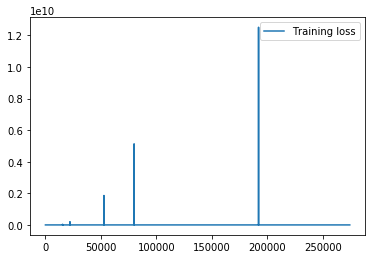

In [27]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
#plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

<h3>Generating training accuracy</h3>

In [108]:
# prediction for training set
output =[]
with torch.no_grad():
    for local_batch, local_labels in training_generator:
        output.append(model(local_batch.float().cuda()))
temp =[]
for x in output:
    softmax = torch.exp(x).cpu()
    prob = list(softmax.numpy())
    temp.extend(prob)
predictions = np.argmax(temp, axis=1)

In [109]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_train, predictions)

0.509913011754244

<h3>Validation set accuracy</h3>

In [104]:
# prediction for training set
output =[]
with torch.no_grad():
    for local_batch, local_labels in validation_generator:
        output.append(model(local_batch.float().cuda()))
temp =[]
for x in output:
    softmax = torch.exp(x).cpu()
    prob = list(softmax.numpy())
    temp.extend(prob)
predictions = np.argmax(temp, axis=1)

In [105]:
accuracy_score(Y_val, predictions)

0.5081726674806842

<h3>Test set accuracy</h3>

In [112]:
test_set = Dataset(X_test, Y_test)
testset_generator = data.DataLoader(validation_set, **params)

In [113]:
# prediction for training set
output =[]
with torch.no_grad():
    for local_batch, local_labels in testset_generator:
        output.append(model(local_batch.float().cuda()))
temp =[]
for x in output:
    softmax = torch.exp(x).cpu()
    prob = list(softmax.numpy())
    temp.extend(prob)
predictions = np.argmax(temp, axis=1)

In [114]:
accuracy_score(Y_test, predictions)

0.5086036179316431